In [ ]:
!pip install tensorflow
!pip install keras
!pip install keras-applications==1.0.7
!pip install image-classifiers==1.0.*
!pip install efficientnet==1.0.*
!pip install -U --pre segmentation-models


In [ ]:
import os
import tensorflow as tf
import glob
import cv2
import numpy as np
from matplotlib import pyplot as pyplot

os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras

In [ ]:
import segmentation_models as sm
# Segmentation Models: using `keras` framework.

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Preparing images
import tifffile as tiff
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list
train_images_dict = {}

for directory_path in sorted(glob.glob("/content/drive/MyDrive/Code Projects/segmentation_model/im_patches")):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.tif")),key=os.path.getctime):
        name = img_path.split('/')[-1].split('.')[0]
        img = cv2.imread(img_path, 1)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        print('name: ', name)
        train_images_dict[name] = img

#Capture mask/label info as a list
train_masks_dict = {}
for directory_path in glob.glob("/content/drive/MyDrive/Code Projects/segmentation_model/bi_patches"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.tif")),key=os.path.getctime):
        name = mask_path.split('/')[-1].split('.')[0]
        mask = tiff.imread(mask_path) #must be imported as a tiffle to conserve labled masks
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks_dict[name] = mask

In [ ]:
train_images = []
train_masks = []

#ensure that the masks and images are lined up masked on the naming convention
#(#_##, ex: 5_21) - 5 says which number image it is, 21 says which section of the image it is,
#there could be other numbers added at the end to specify rotations or other augmentations, etc
#might be best to change this to a recursive functions to take acount any other numbers added to it

for k,v in zip(train_images_dict.keys(),train_images_dict.values()):
  end = ''
  for letter in range(len(k)):
    if k[letter].isnumeric():
      end = k[letter:]
      break
  for x,y in zip(train_masks_dict.keys(),train_masks_dict.values()):
    for letter in range(len(x)):
      #print(x)
      if x[letter].isnumeric():
        endx = x[letter:]

        if end == endx:
          train_images.append(v)
          train_masks.append(y)
        else:
          print(end,endx)
          endx = ''
        break

#print(train_masks)
#print(train_images)

#convert the images to an array so they can be processed by an ml model
train_masks = np.array(train_masks)
train_images = np.array(train_images)


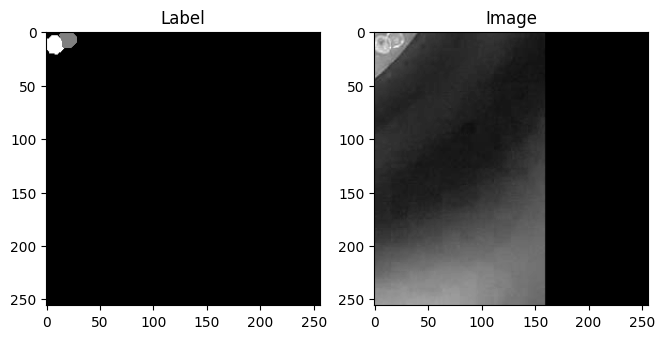

In [ ]:
#Test some random images to make sure they are matched
import random
import matplotlib.pyplot as plt


def error_catcher():
  test_img_number = random.randint(0, len(train_masks)-1)
  test_img = train_masks[test_img_number]
  ground_truth=train_images[test_img_number]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Label')
  plt.imshow(test_img[:,:], cmap='gray')
  plt.subplot(232)
  plt.title('Image')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.show()
error_catcher()

In [ ]:
#check to make sure everything is good
unic = []
for i in train_masks[21]:
  for j in i:
    if j not in unic:
      unic.append(j)
print(unic)

[0, 2]


In [ ]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [ ]:
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background, 1 is not healthy, 2 is healthy

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2]


In [ ]:
#create image augmentaitons
import albumentations as A
images_to_generate = 1000

In [ ]:
#creating model parameters
# we can play around with these to see how they perform on real data
n_classes=3
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

# each epoch takes about 50 seconds of training. SO keep this in mind when
# setting out some time to train the model
history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=60,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

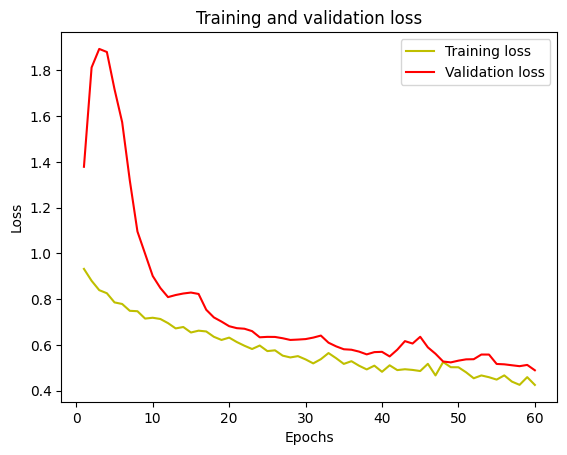

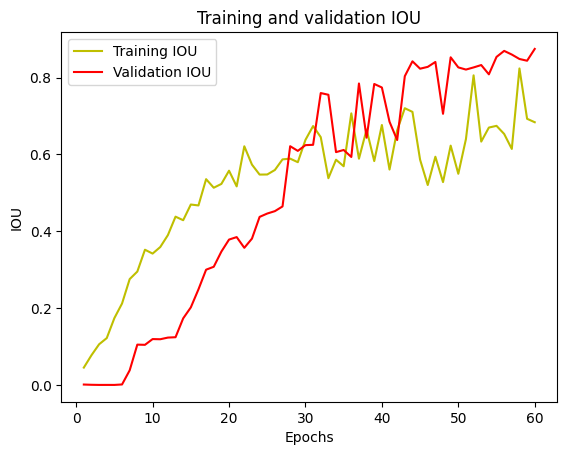

In [ ]:
from keras.utils import normalize
#from keras.metrics import MeanIoU
from matplotlib import pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 [==============================] - 1s 539ms/step


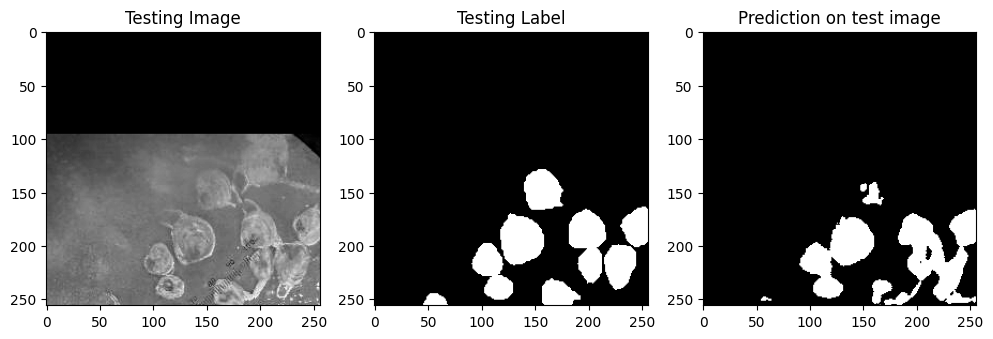

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()